<center>

# __7. Primitives and Qiskit Runtime Service provider__

November 22, 2023

<br>

__Herramientas de la Computación Cuántica__

__Máster en Ciencia y Tecnologías de Información Cuántica (MQIST)__

<br>

Diego Alvarez-Estevez, PhD.

_Centro de Investigación en Tecnologías de la Información y las Comunicaciones (CITIC)_

_Universidade da Coruña_

</center>

## 7.1. Overview 

Qiskit Runtime is a **cloud-based quantum computing service** developed by IBM. It offers computational ```primitives``` to perform foundational quantum computing tasks that utilize ```built-in error suppression and mitigation techniques```. Primitives can be executed inside of ```sessions```, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.

The following figure illustrates how one can use Qiskit Runtime sessions and primitives. The first session request (job) waits through the regular fair-share queue. When it starts to run, the session is started. After the first session job is finished processing, the next job in the session is run without the necessity to restart the queue. This process continues until the session is paused (due to a lack of queued session jobs) or closed.

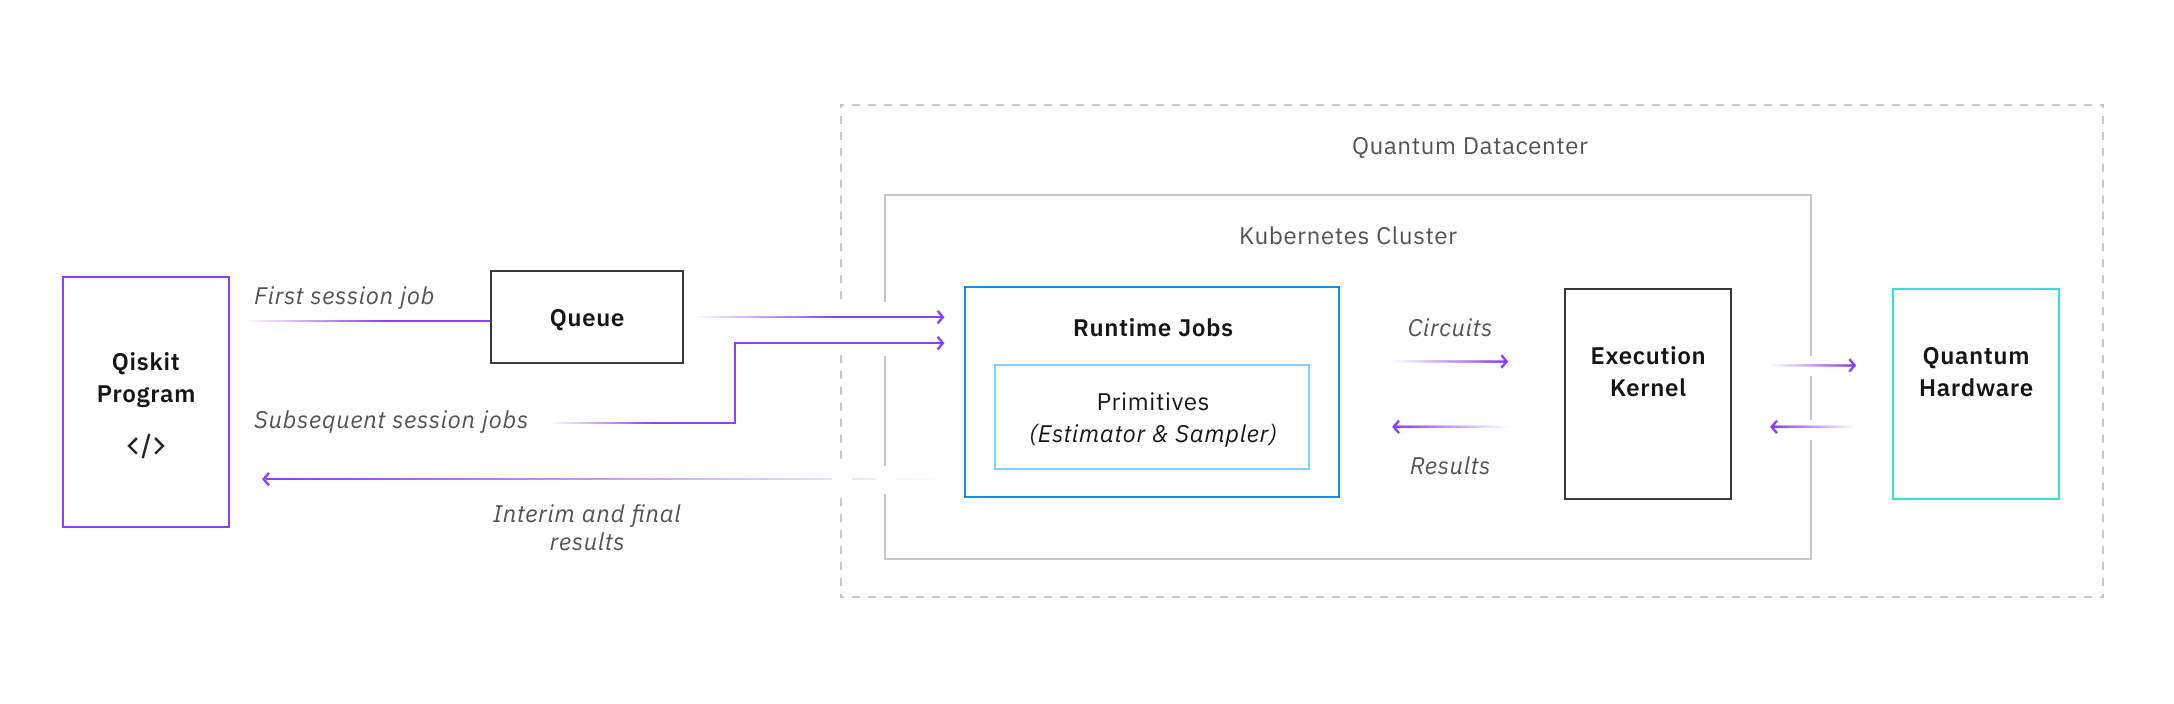

More information:

-<a href=https://qiskit.org/ecosystem/ibm-runtime/index.html>Qiskit Runtime documentation</a>

-<a href=https://github.com/Qiskit/qiskit-ibm-runtime>Qiskit Runtime GitHub project</a>

Installation:

```python
pip install qiskit-ibm-runtime
```

It will also install ```qiskit-ibm-provider``` as dependency

In [12]:
# Version checking
import qiskit_ibm_runtime
import qiskit.tools.jupyter

import sys
print(sys.executable)

%qiskit_version_table

/home/jvazquez/miniconda3/envs/basic-quantum/bin/python


## 7.2. Testing the basic setup

Qiskit Runtime is accessible via two different channels: ```IBM Quantum``` or ```IBM Cloud```. Here we will stick to its use through IBM Quantum, similar to what we did with the ```IBM Provider```

Hence, as for the IBMProvider, we will need to retrieve our IBM Quantum token, and optionally save it for easy access later, or provide it when starting the service for the current session:

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="368ce8e3d58876f8744c71270f2727fd9883b04d75ad646fa5f7345d0b9dede6f06cdc12ebf7e0d0db8a2f0881369da230f432512437401e11ae29dd202b9561")

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

Notice this step is <u>not necessary if you have previously saved it for accessing via the IBM Provider</u>. Also, specifying the channel is only necessary if we have accounts on both ```IBM Quantum``` and ```IBM Cloud``` (otherwise it will be detected automatically).

Now we can test the setup running a basic circuit that connects to the service and uses the ```Sampler``` primitive:

In [14]:
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Starting the service. You'll need to specify the credentials when initializing QiskitRuntimeService, 
# if they are not previously saved.
#service = QiskitRuntimeService(instance="MY_INSTANCE", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService()

# Get the backend through the Runtime Service
backend = service.backend("ibmq_qasm_simulator")

# Run a basic Bell circuit through the Sampler
job = Sampler(backend).run(ReferenceCircuits.bell())
print(f"job id: {job.job_id()}")

# Obtain the results
result = job.result()
print(result)

job id: clqppnvcftmaupnti1p0
SamplerResult(quasi_dists=[{0: 0.51275, 3: 0.48725}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])


/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


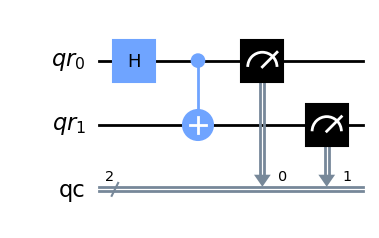

In [15]:
ReferenceCircuits.bell().draw("mpl")

## 7.3. Difference between Qiskit Runtime and IBM Provider backend interfaces

There are two methods for accessing IBM Quantum systems. First, the ```qiskit-ibm-provider``` package provides the ```backend.run()``` interface, allowing direct access to IBM Quantum systems with no pre- or post-processing involved (we have seen this already!). This level of access is suitable for those users who want precise control over circuit execution and result processing. This level of access is needed for those looking to work at the level Kernel developer developing, for example, circuit optimization routines, error mitigation techniques, or characterizing quantum systems.

In contrast, ```Qiskit Runtime``` is designed to streamline algorithm and application construction by removing the need for users to understand technical hardware and low-level software details. Advanced processing techniques for <u>error suppression and mitigation are automtically applied</u>, giving users high-fidelity results without the burdeen of haivng to code these routines themselves. The inclusion of <u>sessions</u> within Qiskit Runtime allows users to run iterative algorithm circuits back to back, or batch collections of circuits without having to re-queue each job. This results in more efficient quantum processor utilization and reduces the total amount of time users spend running complex computations

Check <a href=https://qiskit.org/ecosystem/ibm-runtime/compare.html>backend.run vs. Qiskit Runtime</a> documentation entry for further information

In [16]:
# Let us re-run the code above, now paying more detail to some key aspects
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

qc = ReferenceCircuits.bell()

# Starting the service
service = QiskitRuntimeService()

# Get the backend through the Runtime Service
backend = service.backend("ibmq_qasm_simulator")

# Run a basic Bell circuit through the Sampler
job = Sampler(backend).run(qc) # 1
#job = Sampler().run(qc) # this would fail: A backend or session must be specified (when not using ibm_cloud channel)
#job = backend.run(qc) # 2 this would fail in Runtime < 0.15.0

print(f"job id: {job.job_id()}, type: {type(job)}") # 3

# Obtain the results
result = job.result()
print(result) # 4
#print(result.get_counts()) # Will produce an error if using Sampler primitive

job id: clqppqkp2taogfcbvd6g, type: <class 'qiskit_ibm_runtime.runtime_job.RuntimeJob'>
SamplerResult(quasi_dists=[{3: 0.48275, 0: 0.51725}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])


Some small observations:

1. Notice we are not transpiling the circuit! Runtime Service will take care of these low-level details! Actually, if submitting several jobs on a compatible circuit <u>within a session</u>, transpilation will only take place once (at the remote backend side). More on this later. Regarless, we can also opt for submitting transpiled circuits if we want to. For more information see documentation entry <a href=https://qiskit.org/ecosystem/ibm-runtime/tutorials/user-transpiled-circuits.html>submit user-transpiled circuits using primitives</a>.

2. This would fail for versions of the package <= 0.14.x. Starting with version 0.15.0 Qiskit Runtime [added support for running custom circuits using IBMBackend.run()](https://qiskit.org/ecosystem/ibm-runtime/migrate/backend_run_migration_guide.html) as well, so users can run all programs (whether using Primitives or not) through Runtime. 

3. We get back a <a href=https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html>RuntimeJob</a> instance, which extends the JobV1 interface

4. Results are returned in a <a href=https://qiskit.org/documentation/stubs/qiskit.primitives.SamplerResult.html>SamplerResult instance</a>

## 7.4. Introduction to primitives

In the previous examples we were making use of the ```Sampler()``` primitive.

As introduced, Qiskit primitives represent higher-level abstractions for programming with quantum computers.

The existing Qiskit interface to backends (```backend.run()```) was originally designed to accept a list of circuits and return counts for every job. Over time, it became clear that users have diverse purposes for quantum computing, and therefore the ways in which they define the requirements for their computing jobs are expanding. 

For example, an algorithm researcher and developer cares about information beyond counts; they are more focused on efficiently calculating <u>quasi-probability distribution and expectation values of observables</u>. Obtaining this type of information requires several additional pre- and post-processing coding.

Hence, primitives were introduced which provide methods that make it easier to build modular algorithms and other higher-order quantum programs. Rather than simply returning counts, they return more immediately meaningful information. Additionally, when run through the Runtime Service they provide a seamless way to access the latest optimizations in IBM Quantum hardware and software.

Two basic operations that one can perform with a probability distribution is to sample from it or to estimate quantities on it. Therefore, these operations form the fundamental building blocks of quantum algorithm development. Qiskit provides ```Sampler and Estimator primitives``` for this purpose.

-**Sampler:** Allows a user to input a circuit and then generate quasi-probability distribution.

-**Estimator:** Allows a user to specify a list of circuits and observables and selectively group between the lists to efficiently evaluate expectation values and variances for a parameter input. It is designed to enable users to efficiently calculate and interpret expectation values of quantum operators that are required for many near-term quantum algorithms.

The exact primitive interfaces vary based on the type of task that you want to run on the quantum computer and the corresponding data that you want returned as a result. After identifying the appropriate primitive for your program, you can use Qiskit to prepare inputs, such as circuits, observables (for Estimator), and customizable options to optimize your job.

As a final remark, it is important to highlight that <u>the use of primitives is not exclussive of the Runtime Service</u>. Similar to the [Backend base class](https://qiskit.org/documentation/apidoc/providers.html#backend), there are a [Sampler and Estimator base classes defined in Qiskit Terra](https://qiskit.org/documentation/apidoc/primitives.html) that standardize the way users interact with all Sampler and Estimator implementations. This allows users to easily change their choice of simulator or device for performing expectation value calculations, even if the underlying implementation is different.


### 7.4.1. Getting started with the Sampler primitive

The role of the ```Sampler``` primitive is two-fold: it acts as an entry point to quantum devices or simulators, replacing ```backend.run()```. Additionally, it is an algorithmic abstraction to extract probability distributions from measurement counts.

Both ```Sampler``` and ```backend.run()``` take in circuits as inputs. The main difference is the format of the output: ```backend.run()``` outputs **counts**, while ```Sampler``` processes those counts and outputs the **quasi-probability distribution** associated with them

We will start by using the default Sampler implementation in Qiskit Terra (which uses a local state vector simulator) and compare it with the "classical" counts output generated by the generic (Basic)Aer or IBMProvider simulators. Then we will proceed to use the Sampler implementation that ships with the Qiskit Runtime Service.

<u>Important</u>: If you want to use the Sampler primitive, the circuit **must contain measurements**.

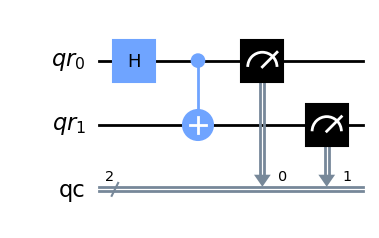

In [17]:
# Firts just load our favourite Bell state circuit
from qiskit.test.reference_circuits import ReferenceCircuits

qc = ReferenceCircuits.bell()

qc.draw("mpl")

In [18]:
# Comparing output of Qiskit Terra's Sampler implementation with count-based backend.run()
from qiskit.primitives import Sampler # Qiskit Terra's implementation, based on local state vector simulator
from qiskit_ibm_provider.job import job_monitor

# Firt, using Sampler() primitive
sampler = Sampler()
job_sampler = sampler.run(qc) # 1

job_monitor(job_sampler)

print(f"Qiskit Terra's sampler Job ID: {job_sampler.job_id()}")

# Get and show the Sampler results
result_sampler = job_sampler.result()
print(result_sampler) # 2

# Convert the Sampler output labels to corresponding bit strings
sampler_qprobs = result_sampler.quasi_dists[0].binary_probabilities() # 2
print(f"  > Qiskit Terra's sampler quasi-probability distribution: {sampler_qprobs}")

# Now using BasicAer simulator
print("\n")

num_shots = 1024

from qiskit import BasicAer, transpile # 3
bAer_backend = BasicAer.get_backend("qasm_simulator")

tqc = transpile(qc, bAer_backend) # We do transpilation here, we are not using a primitive!
job_bAer = bAer_backend.run(tqc, shots=num_shots)

job_monitor(job_bAer)

print(f"BasicAer Job ID: {job_bAer.job_id()}")

# Get and show the BasicAer count results
result_bAer = job_bAer.result()
print(result_bAer)
bAer_counts = result_bAer.get_counts()

print(f"  > BasicAer counts: {bAer_counts}")

# Post-process output to obtain quasi-probabilities
quasi_dists = {}
for key,count in bAer_counts.items():
    quasi_dists[key] = count/num_shots

print(f"  > BasicAer quasi-probability distribution: {quasi_dists}")

Job Status: job has successfully run
Qiskit Terra's sampler Job ID: 49e0b5b7-dcb9-4d85-825b-702ae17ec503
SamplerResult(quasi_dists=[{0: 0.5, 3: 0.5}], metadata=[{}])
  > Qiskit Terra's sampler quasi-probability distribution: {'00': 0.4999999999999999, '11': 0.4999999999999999}


Job Status: job has successfully run
BasicAer Job ID: 1d8f79b9-631d-493b-8a1a-b8a68da047df
Result(backend_name='qasm_simulator', backend_version='2.1.0', qobj_id='8d1f5a54-013e-468d-9ca7-c2cd9497be27', job_id='1d8f79b9-631d-493b-8a1a-b8a68da047df', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 502, '0x3': 522}), header=QobjExperimentHeader(qubit_labels=[['qr', 0], ['qr', 1]], n_qubits=2, qreg_sizes=[['qr', 2]], clbit_labels=[['qc', 0], ['qc', 1]], memory_slots=2, creg_sizes=[['qc', 2]], name='bell', global_phase=0.0, metadata={}), status=DONE, name='bell', seed_simulator=1196026613, time_taken=0.004274606704711914)], date=None, status=CO

First of all, we observe, as expected, that Sampler output directly provides quasi-probability distributions, while using the ```backend.run()``` interface (in this case using BasicAer's QASM simulator backend) we obtain counts, and need to post-process the output.

We notice, however, that both quasi-probability <u>outputs are not exactly the same</u>. More specifically, the output provided by Sampler results in an "exact" distribution, while the one provided by BasicAer is "approximate" or "shot-based" relying on the individually obtained measurement counts. We will come back to this later, but first drag your attention by observing the following notes:  

1. In contrast with previous examples using Runtime Service calls, we do not need to provide "backend" information. This is because Qiskit Terra's implementation is automatically based on a local state vector simulator

2. With Sampler, the output states are no longer represented by bit strings, for example, "11", but by integers, for example, 3. To convert the Sampler output to bit strings, we use the [QuasiDistribution.binary_probabilities()](https://qiskit.org/documentation/stubs/qiskit.result.QuasiDistribution.html#qiskit.result.QuasiDistribution.binary_probabilities) method

3. Using BasicAer for backend.run() interface. We could have used AerSimulator instead. This can be handy for performing simulations with noise models 

<span style="color:red">PRACTICE:</span> Using the same circuit:

1. Obtain similar quasi-probababily distribution outputs using Aer simulator (instead of BasicAer)

2. What would happen if we use "statevector_simulator" instead of "qasm_simulator" with BasicAer? Do we obtain the same effect with Aer? 

In [19]:
# Fill in here with your code and conclusions

Let us dive in a little bit more on the differences between "exact" and "shot-based" simulations. 

One alternative to produce an "exact" simulation with (Basic)Aer simulators, would be to use "statevector" to obtain the amplitude's vector and the associated output probabilities.

On the other hand, Qiskit Terra's implementation of ```Sampler``` lets you perform both, an exact or a shot-based (i.e. noisy, no longer exact) simulation, based on the ```Statevector``` class in the ```qiskit.quantum_info module```.

<span style="color:red">PRACTICE:</span> Modify the initial code above and explore differences in the results when using Qiskit Terra's Sampler with "exact" or "shot-based" simulation

In [20]:
# Comparing output of Qiskit Terra's Sampler implementation with count-based backend.run()
from qiskit.primitives import Sampler # Qiskit Terra's implementation, based on local state vector simulator
from qiskit_ibm_provider.job import job_monitor
from qiskit import BasicAer, transpile
from qiskit.test.reference_circuits import ReferenceCircuits

qc = ReferenceCircuits.bell()

num_shots = 1024

# Firt, using Sampler() primitive
sampler = Sampler()

job_sampler = sampler.run(qc, shots=num_shots) # If shots are specified, this primitive outputs a shot-based simulation (no longer exact)
#job_sampler = sampler.run(qc) # Exact simulation (as in previous version)

job_monitor(job_sampler)

print(f"Qiskit Terra's sampler Job ID: {job_sampler.job_id()}")

# Get and show the Sampler results
result_sampler = job_sampler.result()
print(result_sampler) # Even though, counts-based, we do not explicitly get "counts" in the results, only derived quasi-probabilities!

# Convert the Sampler output labels to corresponding bit strings
sampler_counts = result_sampler.quasi_dists[0].binary_probabilities()
print(f"  > Qiskit Terra's sampler quasi-probability distribution: {sampler_counts}")

# Now using BasicAer simulator
print("\n")

bAer_backend = BasicAer.get_backend("qasm_simulator")

tqc = transpile(qc, bAer_backend) # We do transpilation here, we are not using a primitive!
job_bAer = bAer_backend.run(tqc, shots=num_shots)

job_monitor(job_bAer)

print(f"BasicAer Job ID: {job_bAer.job_id()}")

# Get and show the BasicAer count results
result_bAer = job_bAer.result()
#print(result_bAer)
bAer_counts = result_bAer.get_counts()

print(f"  > BasicAer counts: {bAer_counts}")

# Post-process output to obtain quasi-probabilities
quasi_dists = {}
for key,count in bAer_counts.items():
    quasi_dists[key] = count/num_shots

print(f"  > BasicAer quasi-probability distribution: {quasi_dists}")

# Behaviour is now analogous. Differences we still see, are due to "randomness" inherent to quantum measurement

Job Status: job has successfully run
Qiskit Terra's sampler Job ID: 5375c1b8-e5dc-48a6-901c-b9a401a485f4
SamplerResult(quasi_dists=[{0: 0.50390625, 3: 0.49609375}], metadata=[{'shots': 1024}])
  > Qiskit Terra's sampler quasi-probability distribution: {'00': 0.50390625, '11': 0.49609375}


Job Status: job has successfully run
BasicAer Job ID: 4f39e201-bf62-4687-898d-4bda3280c209
  > BasicAer counts: {'11': 520, '00': 504}
  > BasicAer quasi-probability distribution: {'11': 0.5078125, '00': 0.4921875}


<span style="color:red">PRACTICE:</span> Repeat the simulation but now using the [Aer's implementation](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Sampler.html#qiskit_aer.primitives.Sampler) of the Sampler primitive, comparing the results with default Qiskit's Terra implementation. Try first, using a "shots-based" simulation, then try to produce an "exact" simulation.

In [1]:
from qiskit.primitives import Sampler # Qiskit Terra's implementation, based on local state vector simulator
from qiskit_aer.primitives import Sampler as AerSampler # Aer implementation
from qiskit_ibm_provider.job import job_monitor
from qiskit.test.reference_circuits import ReferenceCircuits

qc = ReferenceCircuits.bell()

num_shots = 1024

# Reference Qiskit's Terra implemetation
sampler = Sampler()

job_sampler = sampler.run(qc) # Now we are not providing the number of shots! => exact simulation

job_monitor(job_sampler)

print(f"Qiskit Terra's sampler Job ID: {job_sampler.job_id()}")

# Get and show the Sampler results
result_sampler = job_sampler.result()
sampler_counts = result_sampler.quasi_dists[0].binary_probabilities()
print(f"  > Qiskit Terra's sampler quasi-probability distribution: {sampler_counts}")

# Now using Aer Sampler implementation
print("\n")
#aer_sampler = AerSampler()
aer_sampler = AerSampler(run_options= {"method": "statevector"})
job_aer = aer_sampler.run(circuits=qc, shots=num_shots)
#job_aer = aer_sampler.run(qc) # Attempt to exact simulation

# Observe AerSampler does not produce an exact simulation! Does not matter if:
#aer_sampler = AerSampler(run_options= {"method": "statevector"})

job_monitor(job_aer)

print(f"Aer sampler Job ID: {job_aer.job_id()}")

# Get and show the Aer Sampler results
result_sampler_aer = job_aer.result()
print(result_sampler_aer) # Notice we also do not get counts for which we are using the Sampler primitive
#print(result_sampler_aer.get_counts()) # This would fail

print(f"  > Aer sampler quasi-probability distribution: {result_sampler_aer.quasi_dists[0].binary_probabilities()}")

Job Status: job has successfully run
Qiskit Terra's sampler Job ID: 7ff4d36d-463c-48bf-a448-6dc2ece1a256
  > Qiskit Terra's sampler quasi-probability distribution: {'00': 0.4999999999999999, '11': 0.4999999999999999}


Job Status: job has successfully run
Aer sampler Job ID: f7af20aa-c44f-4e49-8c16-f77bfd2b978e
SamplerResult(quasi_dists=[{0: 0.4951171875, 3: 0.5048828125}], metadata=[{'shots': 1024, 'simulator_metadata': {'time_taken': 0.0011058, 'num_bind_params': 1, 'parallel_state_update': 4, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.0001304, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 12731, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])
  > Aer sampler quasi

With previous code we notice that, <u>by default, the Aer Sampler does not compute an exact value</u> (unlike the reference ```Qiskit Terra's Sampler``` from ```qiskit.primitives```). To get an exact value we need to explicitly set ```shots=None``` when running the circuit (otherwise it is set by default to 1024). Check the <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Sampler.html>Aer Sampler API reference</a>, where in the number of shots states that: *If None, it calculates the probabilities exactly. Otherwise, it samples from multinomial distributions.*

In [2]:
# Producing exact simulation with Aer Sampler
from qiskit_aer.primitives import Sampler as AerSampler # Aer implementation
from qiskit_ibm_provider.job import job_monitor
from qiskit.test.reference_circuits import ReferenceCircuits

qc = ReferenceCircuits.bell()

# Now using Aer Sampler implementation
print("\n")
aer_sampler = AerSampler()
job_aer = aer_sampler.run(qc, shots=None)

job_monitor(job_aer)

print(f"Aer sampler Job ID: {job_aer.job_id()}")

# Get and show the Aer Sampler results
result_sampler_aer = job_aer.result()
print(result_sampler_aer)

print(f"  > Aer sampler quasi-probability distribution: {result_sampler_aer.quasi_dists[0].binary_probabilities()}")



Job Status: job is actively running

Job Status: job has successfully run
Aer sampler Job ID: 9019c2f3-29df-47b8-a717-de98eac3b953
SamplerResult(quasi_dists=[{0: 0.5, 3: 0.5}], metadata=[{'shots': None, 'simulator_metadata': {'time_taken': 7.07e-05, 'num_bind_params': 1, 'parallel_state_update': 4, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'active_input_qubits': [0, 1], 'num_clbits': 0, 'remapped_qubits': False, 'parallel_shots': 1, 'runtime_parameter_bind': False, 'max_memory_mb': 12731, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'result_subtypes': {'probabilities': 'average'}, 'result_types': {'probabilities': 'save_probabilities_dict'}, 'fusion': {'enabled': False}}}])
  > Aer sampler quasi-probability distribution: {'00': 0.5, '11': 0.5}


Finally, let's re-run the ```Sampler``` primitive <u>through the Runtime Service</u> and experiment with some additional parameters:

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_provider.job import job_monitor
from qiskit.test.reference_circuits import ReferenceCircuits

qc = ReferenceCircuits.bell()

service = QiskitRuntimeService()

# Recall, when using Runtime Service, we need to provide a backend

# Replace "ibmq_qasm_simulator" with your device name to see the complete workflow for a real device.
backend = service.backend("ibmq_qasm_simulator") 
#backend = service.backend("simulator_statevector") # does not make any difference

sampler = Sampler(backend=backend)

job_runtime = sampler.run(qc) # By default shots-based simulation is run with 4000 shots
#job_runtime = sampler.run(qc, shots=1024) # Also shots-based using the specified #shots
#job_runtime = sampler.run(qc, shots=None) # Produces same result, but now it takes 1024 as default 

job_monitor(job_runtime)

result = job_runtime.result()
quasi_dists = result.quasi_dists

print("Runtime sampler result: ", result)
print("Runtime sampler quasi_dists: ", quasi_dists[0].binary_probabilities())

Job Status: job has successfully run
Runtime sampler result:  SamplerResult(quasi_dists=[{0: 0.50275, 3: 0.49725}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])
Runtime sampler quasi_dists:  {'00': 0.50275, '11': 0.49725}


<u>Both Qiskit Terra's and Runtime Service Sampler provide</u> additional possibilities such as passing compound inputs to the ```run()``` method, or use <u>parameterized circuits</u>. For more information, refer to documentation <a href=https://qiskit.org/ecosystem/ibm-runtime/tutorials/how-to-getting-started-with-sampler.html>Get started with the Sampler primitive</a>

The possibility to efficiently run parameterized circuits is specially interesting in the context of Variational Quantum Algorithms (VQA), workhorse for practical applications in the context of today's near-term quantum hardware, in fields like chemistry, binary optimization, or machine learning (will come back to this later). This is specially interesting in combination with additional features provided by the Runtime Service provider.

Indeed, as part of the ```Runtime Service``` the ```Sampler primitive``` offers several additional features and tuning options that do not have _a legacy alternative_, but can help improve your performance and results. For more information, refer to the following:

-<a href=https://qiskit.org/ecosystem/ibm-runtime/tutorials/Error-Suppression-and-Error-Mitigation.html>Error mitigation tutorial</a>

-<a href=https://qiskit.org/ecosystem/ibm-runtime/how_to/options.html>Setting execution options topic</a>

-<a href=https://qiskit.org/ecosystem/ibm-runtime/how_to/run_session.html>How to run a session topic</a>

<span style="color:red">EXERCISE:</span> Execute a circuit using real-hardware with the IBMProvider, obtaining the derived quasi-probabilities from the resulting counts. Run it now with Runtime Service using the Sampler primitive and compare if the returned result is error-mitigated

Should we expect different results? Check the following links:

-https://research.ibm.com/blog/qiskit-runtime-capabilities-integration

-https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options

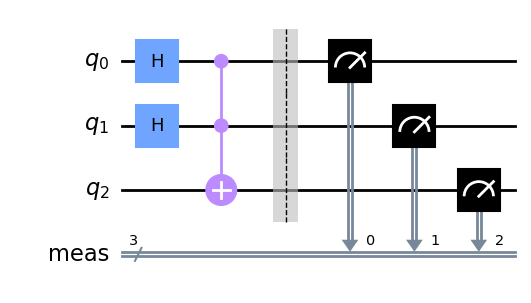

Selected backend:  ibmq_qasm_simulator


ValueError: A backend or session must be specified when not using ibm_cloud channel.

In [6]:
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.h([0,1])
qc.ccx(0,1,2)
qc.measure_all()
display(qc.draw("mpl"))

provider = IBMProvider()

# Using real device
backend = least_busy(provider.backends(min_num_qubits=3, simulator=True, operational=True))

print("Selected backend: ", backend.configuration().backend_name)

sampler = Sampler(backend=backend)
job_runtime = sampler.run(qc)

print(f"Job ID: {job_runtime.job_id()}")

In [ ]:
# In case it takes a big longer...
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram

# Retrieve last job from its id
retrieved_job = provider.retrieve_job("cntschtb08x0008y13sg") # Substitute with proper id
counts = retrieved_job.result().get_counts()
plot_histogram(counts)

### 7.4.2. Getting started with the Estimator primitive

As with the ```Sampler``` primitive, the role of the ```Estimator``` primitive is also two-fold. As primitive, it also acts as an entry point to quantum devices or simulators, replacing the ```backend.run()``` interface. In addition, it is an <u>algorithmic abstraction for expectation value calculations</u> (of quantum circuits and observables), so one does not have to manually construct the final expectation circuit. This results in a considerable reduction of the code complexity and a more compact algorithm design.

Also similar to the ```Sampler``` primitive, one can import specific <u>local</u> ```Estimator``` primitives from ```qiskit_aer.primitives``` and ```qiskit.primitives``` packages. All of them follow the <a href=https://qiskit.org/documentation/stubs/qiskit.primitives.BaseSampler.html>BaseEstimator interface</a>, but only the Runtime implementation offers access to sessions, and built-in error mitigation.

The basic code structure for using (local implementations of) Estimator would result as follows:

```python
from qiskit.primitives import Estimator # For the reference Qiskit Terra's
#from qiskit_aer.primitives import Estimator # For the Aer implementation

# Get local simulator Estimator
estimator = Estimator()

# Run expectation value calculation
result = estimator.run(circuits, observables).result()
```

Let us build now a simple step-by-step example.

To begin with, <u>we will start by using the default implementation in Qiskit Terra</u>, which uses a local state vector simulator.

The first thing we need is a quantum circuit to prepare our system in a precise <u>quantum state for its study</u>:

In [ ]:
from qiskit.circuit.random import random_circuit

# Generate random circuit with 2 qubits and depth=2 (default measure=False), decomposing the main circuit one time
qc = random_circuit(2, 2, seed=0)

display(qc.draw("mpl")) 

qc = qc.decompose(reps=1) 
display(qc.draw("mpl"))

In [ ]:
# Or we could keep using our favourite Bell-state circuit...
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
#qc.measure_all() # We would get an error if including instructions on classical bits

qc.draw("mpl")

Notice one important difference with ```Sampler``` is that, in this case, our circuit <u>SHOULD NOT contain classical bit operations, in particular measurements</u> (as the circuit is meant to represent a quantum state!)

The second thing we need is at least <u>one observable to measure</u>.

Observables represent <u>physical properties</u> of a quantum system (such as energy or spin). The quantum scientist will usually be interested <u>in measuring said properties</u> (such as their [expectation values](https://en.wikipedia.org/wiki/Expectation_value_(quantum_mechanics))) for a given state of reference (represented in this case by our quantum circuit)

In quantum computation, it is usually [mathematically interesting to represent observable operators in terms of Pauli matrices](https://learning.quantum-computing.ibm.com/course/variational-algorithm-design/cost-functions#the-estimator-primitive) (the terms _operator_ and _observable_ are usually used in this context interchangeably). 

For this purpose we can use, for example, the [Pauli](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Pauli.html) or the <a href=https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html#qiskit.quantum_info.SparsePauliOp>SparsePauliOp</a> classes in Qiskit, as illustrated in the following examples:

In [ ]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ") # It will produce concatenation of Pauli-X with Pauli-Z
#observable = SparsePauliOp("Z") # This will fail because the number of qubits in the circuit (2) does not match that of the observable (1) 

print(f"Observable: {observable}")

In [ ]:
# Alternatively
from qiskit.quantum_info import Pauli

observable = Pauli("XZ") # It will produce concatenation of Pauli-X with Pauli-Z

print(f"Observable: {observable}")

Notice an _n_-qubit Pauli may be represented by a string consisting of _n_ characters from ['I', 'X', 'Y', 'Z'], and optionally phase coefficient in ['', '-i', '-', 'i']. For example: XYZ or '-iZIZ'. In the string representation qubit-0 corresponds to the right-most Pauli character, and qubit-_(n-1)_ to the left-most Pauli character. For example 'XYZ' represents $X\otimes Y \otimes Z$ with 'Z' on qubit-0, 'Y' on qubit-1, and 'X' on qubit-3.

We could also define an observable by creating a quantum circuit and [convert it to an operator](https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Converting-classes-to-Operators) (e.g. ```Operator(qc)``` or from a quantum gate (```Operator(qc.to_gate())```).

The final step is to create an instance of the ```Estimator``` class, which can be any of the subclasses that comply with [the base specification](https://qiskit.org/documentation/stubs/qiskit.primitives.BaseEstimator.html#qiskit.primitives.BaseEstimator). As stated before, for now we will use Qiskit Terra’s ```qiskit.primitives.Estimator``` class, based on the <a href=https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html#qiskit.quantum_info.Statevector>Statevector construct</a> (algebraic simulation), we invoke it, and we get the results:

In [ ]:
from qiskit.primitives import Estimator
from qiskit_ibm_provider.job import job_monitor

estimator = Estimator()

job_estimator = estimator.run(qc, observable)
#job_estimator = estimator.run(qc) # will fail, at least one observable must be provided

job_monitor(job_estimator)

print(f"Qiskit Terra's estimator Job ID: {job_estimator.job_id()}")

# Get and show the Estimator results
result_estimator = job_estimator.result()
print(result_estimator)

print(f"  > Qiskit Terra's estimator Expectation value: : {result_estimator.values[0]}")

Wrapping up:

In general, the Estimator primitive is used to estimate expectation values of quantum circuits and observables.

In the example above, using Qiskit Terra's implementation, an estimator is initialized with an empty parameter set. The estimator is used to create a [JobV1](https://qiskit.org/documentation/stubs/qiskit.providers.JobV1.html#qiskit.providers.JobV1), via the [qiskit.primitives.Estimator.run()](https://qiskit.org/documentation/stubs/qiskit.primitives.Estimator.html#qiskit.primitives.Estimator.run) method. In the general form, this method is called with the following parameters:

-quantum circuits ($\psi_i(\theta)$): list of (parameterized) quantum circuits (a list of [QuantumCircuit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit) objects).

-observables ($H_j$): a list of [SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html#qiskit.quantum_info.SparsePauliOp) or [Pauli](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Pauli.html) objects.

-parameter values ($\theta_k$) (not yet used in the example above): list of sets of values to be bound to the parameters of the quantum circuits (list of list of float).

We access the results calling [qiskit.providers.JobV1.result()](https://qiskit.org/documentation/stubs/qiskit.providers.JobV1.html#qiskit.providers.JobV1.result), which yields the list of expectation values (in our case just one) plus optional metadata like confidence intervals for the corresponding estimations $\langle\psi_i(\theta_k)|H_j|\psi_i(\theta_k)\rangle$.  

<span style="color:red">PRACTICE:</span> try with different circuits (states) and observables and compare the results. Try also including measurement instructions in circuit representation and check that an error is returned when running Estimator

In [ ]:
# Fill in here with your code

<span style="color:red">PRACTICE:</span> Let us repeat the simulation above but now using Aer's Estimator implementation, instead of Qiskit Terra's

In [ ]:
from qiskit_aer.primitives import Estimator as AerEstimator # Aer implementation
from qiskit_ibm_provider.job import job_monitor
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Pauli

# Generate random circuit with 2 qubits and depth=2 (default measure=False), decomposing the main circuit one time
qc = random_circuit(2, 2, seed=0)

display(qc.draw("mpl"))

# Define our observable(s)
observable = Pauli("XZ") # It will produce concatenation of Pauli-X with Pauli-Z

# Instantiate the Estimator
estimator = AerEstimator()

job_estimator = estimator.run(qc, observable)

job_monitor(job_estimator)

print(f"Aer's estimator Job ID: {job_estimator.job_id()}")

# Get and show the Estimator results
result_estimator = job_estimator.result()
print(result_estimator)

print(f"  > Aer's estimator Expectation value: : {result_estimator.values[0]}")

Notice, unlike the reference Estimator from ```qiskit.primitives```, by default ```Aer Estimator primitive``` does not compute an exact value (rather produces a "shots-based" simulation). To get an exact value set ```shots=None``` and ```approximation=True```. Check <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Estimator.html>Aer Estimator API<a> for more details

In [ ]:
# Repeating to produce an "exact" simulation
from qiskit_aer.primitives import Estimator as AerEstimator # Aer implementation
from qiskit_ibm_provider.job import job_monitor
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Pauli

# Generate random circuit with 2 qubits and depth=2 (default measure=False), decomposing the main circuit one time
qc = random_circuit(2, 2, seed=0)

display(qc.draw("mpl"))

# Define our observable(s)
observable = Pauli("XZ") # It will produce concatenation of Pauli-X with Pauli-Z

# Instantiate the Estimator
estimator = AerEstimator(approximation=True)

job_estimator = estimator.run(qc, observable, shots=None)

job_monitor(job_estimator)

print(f"Aer's estimator Job ID: {job_estimator.job_id()}")

# Get and show the Estimator results
result_estimator = job_estimator.result()
print(result_estimator)

print(f"  > Aer's estimator Expectation value: : {result_estimator.values[0]}")

To conclude this section, we will run the sampe example, but this time using the Qiskit Runtime Service provider:

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit_ibm_provider.job import job_monitor
from qiskit.circuit.random import random_circuit

# Generate random circuit with 2 qubits and depth=2 (default measure=False), decomposing the main circuit one time
qc = random_circuit(2, 2, seed=0)

display(qc.draw("mpl"))

# Define our observable(s)
observable = Pauli("XZ") # It will produce concatenation of Pauli-X with Pauli-Z

# Initialize Runtime Service and Estimator primitive
service = QiskitRuntimeService()
# Replace "ibmq_qasm_simulator" with your device name to see the complete workflow for a real device.
backend = service.backend("ibmq_qasm_simulator") 

sampler = Estimator(backend=backend)

job_runtime = sampler.run(qc, observable)

job_monitor(job_runtime)

result = job_runtime.result()

print("Runtime estimator result: ", result)
print("Runtime estimator expectation value: ", result.values[0])

We conclude this section by recalling that the Estimator Runtime primitive offers a series of features and tuning options that do not have a legacy alternative (i.e. with (Basic)Aer simulators or IBMProvider), but can help improve performance and quality of the results. For more information, refer to the following:

https://qiskit.org/ecosystem/ibm-runtime/tutorials/how-to-getting-started-with-estimator.html

https://qiskit.org/ecosystem/ibm-runtime/migrate/migrate-estimator.html

The last link does also illustrate the Estimator workflow with a more practical step-by-step example for chemistry, were we would like to compute the expectation value of a quantum circuit using the H2 molecule.

Additional resources on the use of primitives and other useful uses cases (for example, evaluation of cost functions in optimization problems) can be found through the following links:

https://docs.quantum-computing.ibm.com/run/primitives

https://learning.quantum-computing.ibm.com/course/variational-algorithm-design/cost-functions#primitives

While deep understanding of practical cases included in above examples is out of the scope of this course, in the following section we try to approach a closer intuition of what Estimator is actually doing by exploring one simpler example


### 7.4.3. Playing with expectation values. What is Estimator actually doing?

Let us go through a easy-to-follow 1-qubit example, and reexamine the calculation of expectation values.

For this purpose, we will take as reference a simple circuit that allow us to initialize the quantum state to our will, and then compute the resulting expectation values with respect to the individual Pauli-X, Pauli-Y, and Pauli-Z matrices (that will act as our observables).

First of all, let us solve this analytically, so that we know what we are doing, and what to expect.

<span style="color:red">PRACTICE:</span> Let us do it!

Then let us run the following code to check the results of our analysis:

In [ ]:
# Calculating expectation values using one-gate example

from qiskit import QuantumCircuit
import numpy as np
# For plotting statevector in Bloch sphere, useful for geometric interpretation
# plot_bloch_vector works with Bloch coordinates, not directly statevectors!
# plot_bloch_multivector does the transformation automatically. 
# In later code block we will show the explicit transformation to retrieve (x,y,z) coordinates and plot with "plot_bloch_vector"
from qiskit.visualization import plot_bloch_multivector 

# Initialize circuit with one qubit
qc = QuantumCircuit(1)

# Define our custom state by setting probability amplitudes
a = 1/np.sqrt(2); b = 1/np.sqrt(2) # |+> state => equal superposition (same as applying Hadamard)
# We can solve this case analitically, and get to the conclusion that Z-expectation should be 0, 
# X-expectation 1, and Y-expectation will also be 0

# Prepare (normalized) quantum state
raw_state = np.array([a, b])
norm_factor = np.linalg.norm(raw_state)
norm_state = raw_state / norm_factor
initial_state = norm_state

print("Initial state: ", initial_state)

# Draw resulting state vector in Bloch Sphere (will be useful for geometric interpretation)
display(plot_bloch_multivector(initial_state), "Initialization state") # See comments at beginning of this script

# Initialize our one-qubit quantum circuit to the given state
qc.initialize(initial_state, 0) # Second parameter indexes the qubit. In this case same as qc.initialize(initial_state)
#qc.initialize(raw_state, 0, normalize=True) # Equivalent

# Draw resulting circuit state 
# Uncomment to check that it produces same result as above
from qiskit.quantum_info import Statevector
circuit_state = Statevector(qc)
display(plot_bloch_multivector(circuit_state), "Circuit state")

# Draw the resulting circuit
display(qc.draw("mpl"))

# Now use Estimator primitive to obtain expectation values 
# and check that results matches expected output from analytical calculation
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator # using qiskit terra's implementation

# Observable(s)
observable_1 = SparsePauliOp("Z")
observable_2 = SparsePauliOp("X")
observable_3 = SparsePauliOp("Y")

# Initialize estimator
estimator = Estimator()

# Get and show the Estimator results
job_estimator = estimator.run(qc, observable_1)
result_estimator = job_estimator.result()
print(f"  > Qiskit Terra's estimator Z-Expectation value: : {result_estimator.values[0]}")

job_estimator = estimator.run(qc, observable_2)
result_estimator = job_estimator.result()
print(f"  > Qiskit Terra's estimator X-Expectation value: : {result_estimator.values[0]}")

job_estimator = estimator.run(qc, observable_3)
result_estimator = job_estimator.result()
print(f"  > Qiskit Terra's estimator Y-Expectation value: : {result_estimator.values[0]}")

<span style="color:red">PRACTICE:</span> Try different initializations, calculate expected results analytically, and run the code again to check the results. For example:

-a = 1; b = 1

-a = 1; b = 2

-a = 2/3; b = 1/3

-a = 1/sqrt(2), b = -i/sqrt(2)


Do we see any relationship between the obtained expected values, and the statevector representation in the Bloch sphere?

In [ ]:
# Practice here and write your conclusions

In fact, we can see that there is a correspondence between <u>the projection</u> of the resulting statevector in the (X,Y,Z) basis components (axes of the Bloch Sphere) and the resulting expected values: 

<u>The modulus</u> of the expectation value <u>corresponds to the length of the projection</u> of the state vector in the corresponding axis, and <u>the sign</u> with its <u>orientation</u> (i.e. if projecting toward X- or X+ axis, for example). Also notice, because the radious of the Bloch sphere equals 1, hence the maximum length of the projection is 1. 

You can check that we always get expectation values in the range [-1,1]

Now, we will consider the relationship between the state vector representation and the corresponding cartesian coordinates in the Bloch sphere. So, we take a look once more to the Bloch Sphere representation:

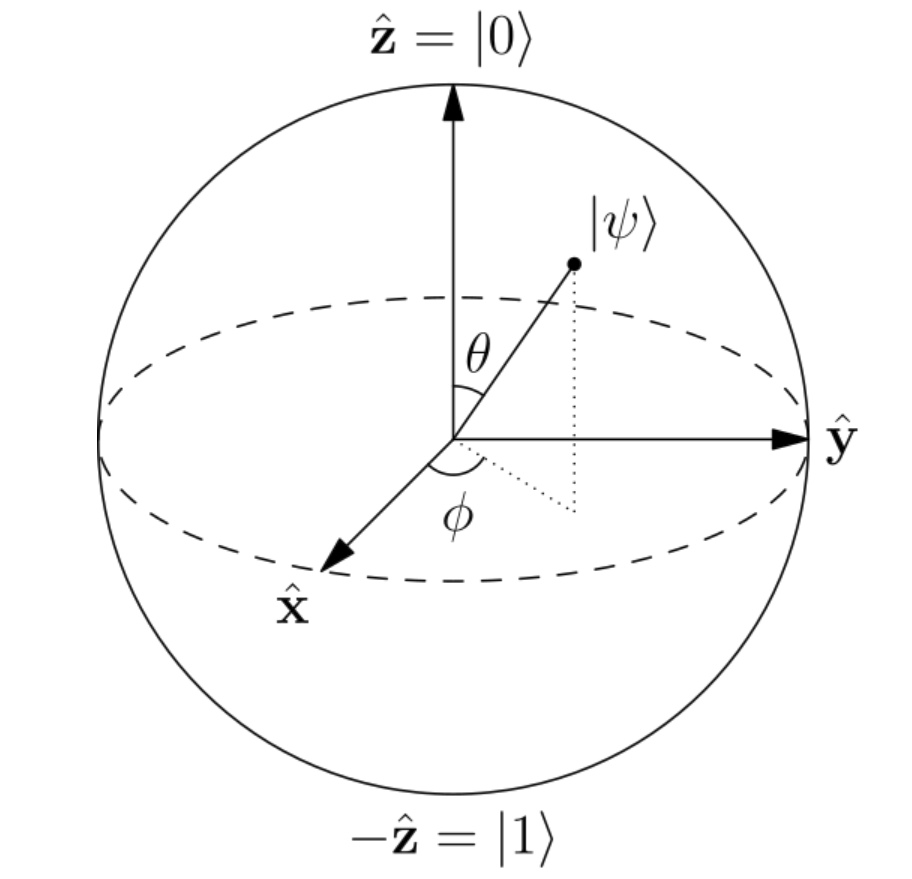

In order to calcualte cartesian coordinates (x,y,z), corresponding to our 1-qubit vector state, let's first to calculate the spherical coordinates 'theta'(θ) and 'phi'(φ). 

For the Bloch sphere the spherical coordinates are (r, θ, φ). Since the radius of the Bloch sphere is 1, we have that r = 1, and theta is the angle that our statevector makes with the Z-axis (polar angle), while phi is the angle that the projection of the state on the XY-plane makes with X-axis.

The relatioinship between a two dimensonal (1-qubit) state vector |ψ⟩ and the spherical coordinates is represented by:

|ψ⟩ = (r0)e^i(ϕ0)|0⟩ + (r1)e^i(ϕ1)|1⟩

Based on this relationship, the following code retrieves the spherical coordinates from an input state vector:


In [ ]:
# Code to obtain spherical coordinates of 1-qubit statevector
def get_spherical_coordinates(statevector):
    # Convert to polar form:
    r_0 = np.abs(statevector[0])
    phi_0 = np.angle(statevector[0])

    r_1 = np.abs(statevector[1])
    phi_1 = np.angle(statevector[1])

    # Calculate the coordinates:
    r = np.sqrt(r_0 ** 2 + r_1 ** 2) # should always be one in principle (total probability, radius of Bloch sphere)
    theta_angle = 2 * np.arccos(r_0 / r)
    phi_angle = phi_1 - phi_0
    return [r, theta_angle, phi_angle]

And once we have calculate theta and phi, we can calculate the cartesian cordinates with the following relations:

X = r*sin(θ)*cos(φ),

Y = r*sin(θ)*sin(φ),

Z = r*cos(θ)

So we can now recover both the spherical and cartesian coordinates from an input state vector and use "plot_bloch_vector" to represent the corresponding state:

In [ ]:
# Obtain expectation values as the corresponding projections with cartesian coordinates in Bloch sphere:
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector

# Our state vector
psi = initial_state # from previous code block

display(plot_bloch_multivector(psi, "from state vector (plot_bloch_multivector)"))

# Now obtain first, spherical coordinates
sph_cord = get_spherical_coordinates(psi)
print("Spherical coordinates (r, theta, phi):", sph_cord)

# We can now use the function "plot_bloch_vector" using these coordinates
display(plot_bloch_vector(sph_cord, title="from spherical coordinates (plot_bloch_vector)", coord_type = 'spherical'))
# Warning!!, for some reason previous call to plot_bloch_vector alters values of "sph_cord"!!
print("Spherical coordinates (r, theta, phi) (wrong):", sph_cord)
sph_cord = get_spherical_coordinates(psi) # Thus, we recalculate them (because of previous warning)
print("Spherical coordinates (r, theta, phi) (corrected):", sph_cord)

# Obtain now the cartesian coordinates
x_coord = sph_cord[0]*np.sin(sph_cord[1])*np.cos(sph_cord[2])
y_coord = sph_cord[0]*np.sin(sph_cord[1])*np.sin(sph_cord[2])
z_coord = sph_cord[0]*np.cos(sph_cord[1])

cart_coord = [x_coord, y_coord, z_coord]

print("Cartesian coordinates (x, y, z):", cart_coord)

display(plot_bloch_vector(cart_coord, title="from cartesian coordinates (plot_bloch_vector)", coord_type = 'cartesian'))

# And we can check, that these coordinates correspond to the expected values of our state 
# for corresponding Pauli-X, Pauli-Y, and Pauli-Z observables. 
# Indeed as they represent the corresponding axis projections

# Obtain projection on X-axis according to formula above
print("(X-expectation) Projection on X: ", x_coord) 
# Analogously for Pauli-Y and Pauli-Z operators:
print("(Y-expectation) Projection on Y: ", y_coord) 
print("(Z-expectation) Projection on Z: ", z_coord)

# Compare the obtained values with those output using Estimator in preceding code block

Now, we have analitically derived that Z-expectation, $\langle\psi|Z|\psi\rangle$, can be calculated as p(0)-p(1)

Another way of getting to the same result is by noticing that:

$Z = |0\rangle\langle0| - |1\rangle\langle1|$

This means we can write the expectation of $Z$ as: 

\begin{equation}
\begin{split}
   \langle\psi|Z|\psi\rangle & = \langle\psi|0\rangle\langle0|\psi\rangle-\langle\psi|1\rangle\langle1|\psi\rangle \\
                             & = |\langle0|\psi\rangle|^2 - |\langle1|\psi\rangle|^2 \\
                             & = p(0) - p(1)
\end{split}
\end{equation}

Hence we could execute a count-based simulation to compute the value $\langle\psi|Z|\psi\rangle$, i.e. without the need to rely on the Estimator primitive:

We initialize our circuit state the state $|\psi\rangle$ and perform a measurement. Repeat this a #shots times to get the counts distribution and then derive the corresponding probabilities:

In [ ]:
from qiskit import QuantumCircuit, BasicAer, transpile
import numpy as np
from qiskit.visualization import plot_bloch_multivector  

# Define our custom state by setting probability amplitudes
a = 1/np.sqrt(2); b = 1/np.sqrt(2) # |+> state => equal superposition (same as applying Hadamard)
# We can solve this case analitically, and get to the conclusion that Z-expectation should be 0, 
# X-expectation 1, and Y-expectation will also be 0

# Prepare (normalized) quantum state
raw_state = np.array([a, b])
norm_factor = np.linalg.norm(raw_state)
norm_state = raw_state / norm_factor
initial_state = norm_state

print("Initial state: ", initial_state)

# Draw resulting initialization state
display(plot_bloch_multivector(initial_state), "Initialization state")

# Initialize our one-qubit quantum circuit to certain specific state
qc = QuantumCircuit(1)
qc.initialize(initial_state, 0)

# Adding measurement step to previously defined circuit, so we can get counts with "qasm_simulator"
qc.measure_all() 

# Drawing the Quantum Circuit
display(qc.draw("mpl"))

# Run the simulation
num_shots = 1000

backend = BasicAer.get_backend("qasm_simulator")
tqc = transpile(qc, backend)
job = backend.run(tqc, shots = num_shots)

counts = job.result().get_counts()
quasi_probs = [counts.get('0',0)/ num_shots, counts.get('1',0)/ num_shots] 

print("Simulation counts:", counts)
print("Corresponding quasi-probabilities:", quasi_probs)
print("Derived Z-expectation:", quasi_probs[0] - quasi_probs[1])

# Check result using Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator # using qiskit terra's implementation

# Observable(s)
observable_1 = SparsePauliOp("Z")

# Initialize estimator
estimator = Estimator()

# Remove measurements from initial circuit, otherwise Estimator will produce an error
qc.remove_final_measurements()
#display(qc.draw("mpl"))

# Get and show the Estimator results
job_estimator = estimator.run(qc, observable_1)
result_estimator = job_estimator.result()
print(f"Qiskit Terra's estimator Z-Expectation value: : {result_estimator.values[0]}")

We might see some small differences due to the fact that Estimator is here using an exact simulation, in contrast with our count-based derivation

<span style="color:red">PRACTICE:</span> Is there a way we can do something similar for Pauli-X and Pauli-Y? (i.e. relying on measurement results)

Well, yes...using what is known as the _post-rotation technique_, which relies on the fact that these operators can be related to $Z$ via the following transformations: $HZH=X$ and $SHZHS^\dagger=Y$

In particular:

$$ 
\begin{split}
\langle\psi|X|\psi\rangle & = \langle\psi|HZH|\psi\rangle \\
                          & = \langle\psi H|0\rangle\langle0|H\psi\rangle-\langle\psi H|1\rangle\langle1|H\psi\rangle\\
                          & = |\langle0|H\psi\rangle|^2 - |\langle1|H\psi\rangle|^2
\end{split}
$$

Therefore, to estimate this expectation value, we apply a post-rotation ($H$) to the circuit $\psi$ and then measure in the computational basis.

Similarly for the expectation value of $Y$:

$$ 
\begin{split}
\langle\psi|Y|\psi\rangle & = \langle\psi|SHZHS^\dagger|\psi\rangle \\
                          & = \langle\psi SH|0\rangle\langle0|HS^\dagger\psi\rangle-\langle\psi SH|1\rangle\langle1|HS^\dagger\psi\rangle\\
                          & = |\langle0|HS^\dagger\psi\rangle|^2 - |\langle1|HS^\dagger\psi\rangle|^2
\end{split}
$$

In this case, we can add the post-rotation $HS^\dagger$ to the circuit.

Let us examine that for Pauli-X case:

In [ ]:
from qiskit import QuantumCircuit, BasicAer, transpile
import numpy as np
from qiskit.visualization import plot_bloch_multivector  

# Define our custom state by setting probability amplitudes
a = 1; b = 2

# Prepare (normalized) quantum state
raw_state = np.array([a, b])
norm_factor = np.linalg.norm(raw_state)
norm_state = raw_state / norm_factor
initial_state = norm_state

# Initialize our one-qubit quantum circuit to certain specific state
qc = QuantumCircuit(1)
qc.initialize(initial_state, 0)

qc.h(0) # Apply corresponding H post-rotation before measurement

# Adding measurement step to previously defined circuit, so we can get counts with "qasm_simulator"
qc.measure_all() 

# Drawing the Quantum Circuit
display(qc.draw("mpl"))

# Run the simulation
num_shots = 1000

backend = BasicAer.get_backend("qasm_simulator")
tqc = transpile(qc, backend)
job = backend.run(tqc, shots = num_shots)

counts = job.result().get_counts()
quasi_probs = [counts.get('0',0)/ num_shots, counts.get('1',0)/ num_shots] 

print("Simulation counts:", counts)
print("Corresponding quasi-probabilities:", quasi_probs)
print("Derived X-expectation:", quasi_probs[0] - quasi_probs[1])

# Check result using Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator # using qiskit terra's implementation

# Observable(s)
observable_1 = SparsePauliOp("X")

# Initialize estimator
estimator = Estimator()

# Use same circuit but removing the post-rotation gate and the measurement operation
qc = QuantumCircuit(1)
qc.initialize(initial_state, 0)
display(qc.draw("mpl"))

# Get and show the Estimator results
job_estimator = estimator.run(qc, observable_1)
result_estimator = job_estimator.result()
print(f"Qiskit Terra's estimator X-Expectation value: : {result_estimator.values[0]}")

<span style="color:red">EXERCISE:</span> Now you do the same, but for the Pauli-Y operator

In [ ]:
# Fill in here with your code

We have seen how the post-rotation techinique works for simple Pauli matrices and for one-qubit example. This can be understood as a change of basis to project out state vector in the Z-axis, which is where we conventionally perform measurements. We can think of Qiskit's implementation of Estimator as automatically performing this operation _behind the curtain_ for the more general case with larger number of qubits and more complex forms of observables.

And if we just hadn't had enough, just to conclude this section, we introduce yet another way to compute expectation values, in this case using the [expectation_value method](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html#qiskit.quantum_info.Statevector.expectation_value) available through Statevector class objects  

In [ ]:
# Another way to do it
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp

psi = Statevector(qc)
print(psi)

# Observable(s)
observable_1 = SparsePauliOp("Z")
observable_2 = SparsePauliOp("X")
observable_3 = SparsePauliOp("Y")

print("Z-expectation exact: ", psi.expectation_value(observable_1).real)
print("X-expectation exact: ", psi.expectation_value(observable_2).real)
print("Y-expectation exact: ", psi.expectation_value(observable_3).real)

### 7.4.4. Using sessions and parameterized circuits with Qiskit Runtime

A Qiskit Runtime ```session``` allows you to group a collection of iterative calls to the quantum computer. A session is started when the first job within the session is started. Provided the session is active, subsequent jobs within the session are prioritized by the scheduler to minimize artificial delay within an iterative algorithm. Data used within a session, such as transpiled circuits, is also cached to avoid unnecessary overhead.

Notice there are some restrictions with regard to the <a href=https://qiskit.org/ecosystem/ibm-runtime/faqs/max_execution_time.html>maximum session and execution times</a> for Qiskit Runtime jobs.

Let us develop one general example on how to configure a session with Qiskit Runtime Service. For simplicity, let us start using the Sampler primitive:

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.circuit.random import random_circuit

# Initialize the service and get the backend
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

# Instatiate a circuit
circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
display(circuit.draw("mpl"))

with Session(backend=backend, max_time="1h"):
    sampler = Sampler()

    result = sampler.run(circuit).result()
    print(f">>> Quasi-probability distribution from the first run: {result.quasi_dists[0]}")

    result = sampler.run(circuit).result()
    print(f">>> Quasi-probability distribution from the second run: {result.quasi_dists[0]}")

Actually, we are not restricted to use just one type of primitive in a session:

In [ ]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    Sampler,
    Estimator,
    Options,
)
from qiskit.quantum_info import SparsePauliOp 

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum")

# 2. Instatiate the circuits
circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
estimator_circuit = circuit.remove_final_measurements(inplace=False)
display(circuit.draw("mpl"))
display(estimator_circuit.draw("mpl"))

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)
observable = SparsePauliOp("IY") # for estimator

# 3. Select a backend.
backend = service.backend("ibmq_qasm_simulator")

# 4. Create a session
with Session(backend=backend):
    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(circuit)
    estimator_job = estimator.run(estimator_circuit, observable)

    # 7. Get results
    print(
        f">>> Quasi-probability distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}")


Now let us leverage Qiskit Runtime Service capabilities for <a href=https://qiskit.org/ecosystem/ibm-runtime/migrate/migrate-update-parm.html>running parameterized circuits</a> enabling practical quantum algorithms, such as VQA's.

**Variational Quantum Algorithms (VQA)** use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. We are thus in the realm of hybrid classical-quantum computation.

```python
Try parameters -> Calculate expectation value -> Feed returned value into classical optimizer -> Get new set of parameters -> ... repeat until certain threshold or condition is met
```

VQA's are very popular in the current noisy intermediate-scale quantum (NISQ) era as they typically require fewer gates and qubits, therefore they are relatively resiliant to noise, yet they can find application with potential quantum advantage for certain type of problems.

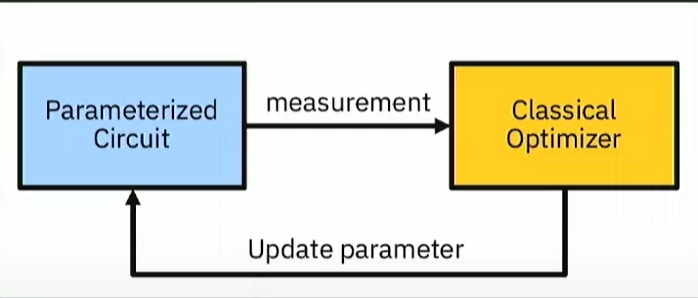

Running VQA's before Qiskit Runtime:

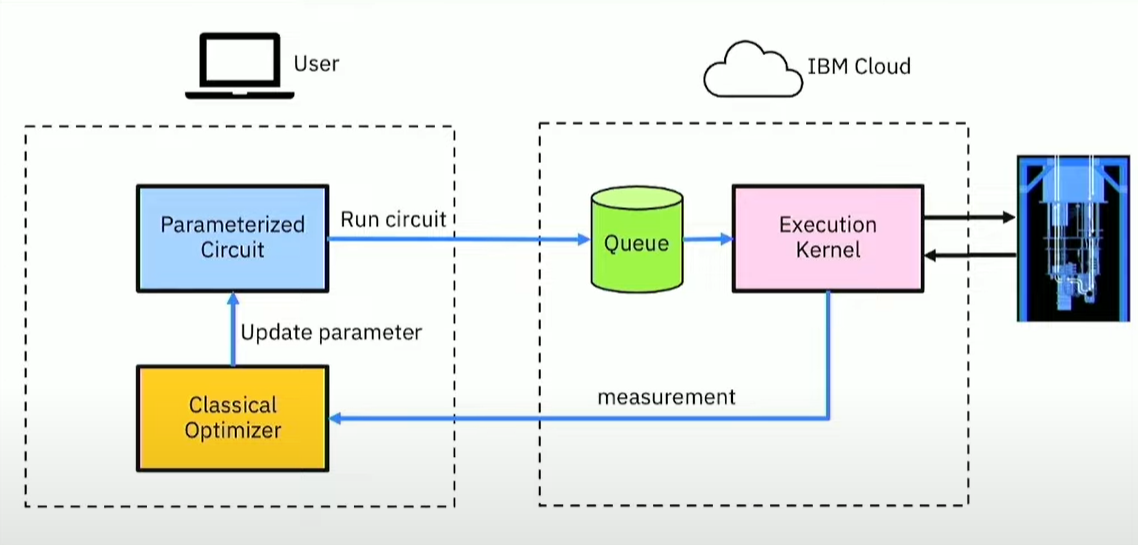

Running circuits using Qiskit Runtime:

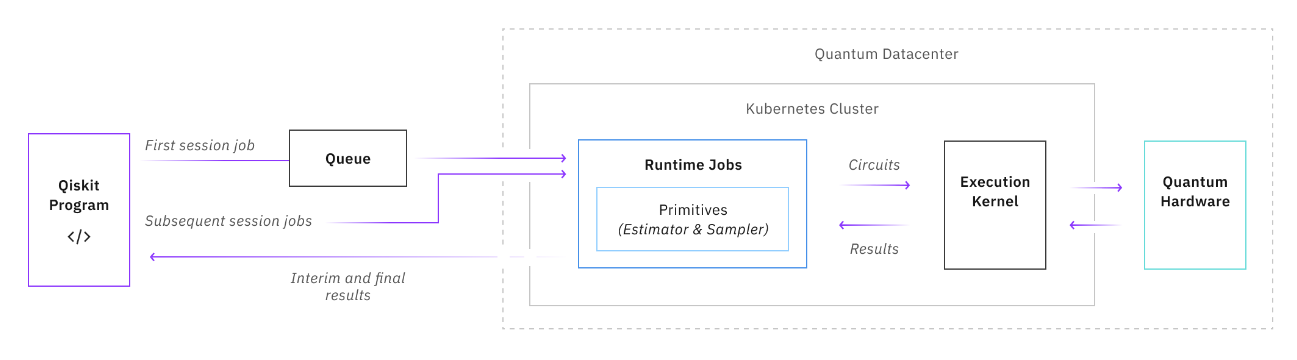

Qiskit Runtime sessions reduce I/O overhead for applications, such as VQA's, that need many iterations that use both quantum and classical processing. In addition, when running parameterized circuits with Qiskit Runtime Service, transpilation (which might be computational demanding) will take place normally just once (at the beginning of the session) then new parameters can be bound without the need to transpiling again (basically, because gates in the circuit do not change, just their parameters).

Qiskit Runtime primitives also simplify the interfaces and pre- and post-processing needed to perform foundational quantum computing tasks with built-in optimization

Thus, let us run an example to wrap this all together using the Sampler primitive:


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

# We will load two different parameterized circuits from the library with different number of parameters
pqc = RealAmplitudes(num_qubits=2, reps=2)
pqc.measure_all()

print(f"The circuit has {pqc.num_parameters} parameters")
display(pqc.decompose().draw("mpl"))

# Second circuit
pqc2 = EfficientSU2(num_qubits=2, reps=1)
pqc2.measure_all()

print(f"The circuit has {pqc2.num_parameters} parameters")
display(pqc2.decompose().draw("mpl"))

# Setup Qiskit Runtime connection and get (the least busy) backend
service   = QiskitRuntimeService(channel="ibm_quantum")

#backend = service.least_busy(simulator=False, min_num_qubits=5)
# We can examine the configuration and properties of the returned backend
#print(f"Backend {backend.name} has {backend.configuration().num_qubits} qubits.")
#print(f"T1 value for qubit 0 is {backend.properties().t1(0)}s")

# Or just work with the simulator (to speed up the process)
backend = "ibmq_qasm_simulator"

# Configure potential set of parameters we want to try
theta1 = [0, 1, 1, 2, 3, 5] # One first parameter set for circuit 1
theta2 = [1, 2, 3, 4, 5, 6] # One second parameter set for circuit 1
theta3 = [0, 1, 2, 3, 4, 5, 6, 7] # A parameter set for circuit 2

# Open a session with the sampler, providing different set of circuits and parameters to try
with Session(service=service, backend=backend) as session:
    
    # Initialize the sampler
    sampler = Sampler()
    #sampler = Sampler(session=session) # Actually not necessary for which it is run within a session context manager   
    
    job_1 = sampler.run(circuits=[pqc], parameter_values=[theta1], shots=2000)
    print(f"Result from circuit 0 with parameter set {theta1}:\n {job_1.result()}\n")
    
    job_2 = sampler.run(circuits=[pqc, pqc], parameter_values=[theta1, theta2])
    print(f"Result from circuit 0 with parameters sets {theta1, theta2}:\n {job_2.result()}\n")
    
    job_3 = sampler.run(circuits=[pqc, pqc2], parameter_values=[theta1, theta3])
    print(f"Result from circuits 0, 1 with parameters sets {theta1, theta3}:\n {job_3.result()}")

    # Close the session only if all jobs are finished, and you don't need to run more in the session
    session.close()

Now, notice the example above <u>still does not involve an interative process</u>.

We show now how to prepare an interative process using a simple example:

-We prepare a parameterized circuit that takes 1 parameter, ```theta```, which determine the degree of rotation around the x-axis in the Bloch sphere (i.e. somewhere between straight up and straight down).

-After each iteration, we increment the value of ```theta``` depending on the probability of getting a 1 obtained in the previous iteration.

-For example, if from the previous job a distribution of {'0': 0.65, '1': 0.35} was obtained, the next job will run with ```theta += 0.35 * pi```

-The loop stops when the probability of getting a 1 reaches >= 50%

-> of course, the more ```theta``` approaches to ```pi```, the closer and closer we will get to ```prob(1) = 1```

<span style="color:red">PRACTICE:</span> If we would start in the ground state with ```0.25 * pi```, what expected probability distribution we would get after the first iteration?

In [ ]:
# Fill in here with your code and your conclusions

Let us now show the code for the complete execution, using as starting point $\pi/8$

In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit
import numpy as np
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Session

# Create a custom parameterized circuit.
theta = Parameter('θ')
qc = QuantumCircuit(1)
qc.rx(theta, 0)
qc.measure_all()
display(qc.draw("mpl"))

theta_val = np.pi/8

service   = QiskitRuntimeService(channel="ibm_quantum")

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    
    # Initialize the sampler
    sampler = Sampler() 
    
    result = sampler.run(circuits=[qc], parameter_values=[theta_val], shots = 100).result()

    while result.quasi_dists[0].get(1, 0) < 0.5:
        print(f"Result is {result.quasi_dists} when using theta {theta_val}")
        
        # get (key, default_value if key not found), so at least we get some increment
        theta_val += (result.quasi_dists[0].get(1, 0.1) * np.pi) 
        result = sampler.run(circuits=[qc], parameter_values=[theta_val], shots=100).result()

    print(f"All done. Result is {result.quasi_dists} when using theta {theta_val}")


<span style="color:red">EXERCISE:</span> Run an VQA using Qiskit Runtime, this time using the Estimator primitive, in which parameters for each iteration are conditioned to certain result obtained in previous iteration until certain target condition is met

In [ ]:
# Fill in here with your code